# • DOMAIN: Smartphone, Electronics

**• CONTEXT: India is the second largest market globally for smartphones after China. About 134 million smartphones were sold across India in the year 2017 and is estimated to increase to about 442 million in 2022. India ranked second in the average time spent on mobile web by smartphone users across Asia Pacific. The combination of very high sales volumes and the average smartphone consumer behaviour has made India a very attractive market for foreign vendors. As per Consumer behaviour, 97% of consumers turn to a search engine when they are buying a product vs. 15% who turn to social media. If a seller succeeds to publish smartphones based on user’s behaviour/choice at the right place, there are 90% chances that user will enquire for the same. This Case Study is targeted to build a recommendation system based on individual consumer’s behaviour or choice.**

**• DATA DESCRIPTION:**

> **• author : name of the person who gave the rating**

> **• country : country the person who gave the rating belongs to**

> **• data : date of the rating**

> **• domain: website from which the rating was taken from**

> **• extract: rating content**

> **• language: language in which the rating was given**

> **• product: name of the product/mobile phone for which the rating was given**

> **• score: average rating for the phone**

> **• score_max: highest rating given for the phone**

> **• source: source from where the rating was taken**

**• PROJECT OBJECTIVE: We will build a recommendation system using popularity based and collaborative filtering methods to recommend mobile phones to a user which are most popular and personalised respectively**

### Importing Libraries and Data Warehousing

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
from surprise import Dataset,Reader
from surprise.model_selection import cross_validate
from surprise import NormalPredictor
from surprise import SVD, KNNWithMeans
from surprise import accuracy
from surprise.model_selection import train_test_split
from surprise.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import os

In [2]:
!pip install scikit-surprise # to install surprise package

     |████████████████████████████████| 11.8MB 24.5MB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp37-cp37m-linux_x86_64.whl size=1617656 sha256=d1c1de337d8566def01183c2f6890d5be9a0aba58082350f1e9a9c6c261f17bc
  Stored in directory: /root/.cache/pip/wheels/78/9c/3d/41b419c9d2aff5b6e2b4c0fc8d25c538202834058f9ed110d0
Successfully built scikit-surprise


 Merging all CSVs into one Dataframe

In [5]:
df1=pd.read_csv('/content/phone_user_review_file_1.csv',encoding='latin1')
df2=pd.read_csv('/content/phone_user_review_file_2.csv',encoding='latin1')
df3=pd.read_csv('/content/phone_user_review_file_3.csv',encoding='latin1')
df4=pd.read_csv('/content/phone_user_review_file_4.csv',encoding='latin1')
df5=pd.read_csv('/content/phone_user_review_file_5.csv',encoding='latin1')
df6=pd.read_csv('/content/phone_user_review_file_6.csv',encoding='latin1')

In [6]:
df=df1.append([df2,df3,df4,df5,df6]) #since we have same columns we are appending the each dataframe.

**Data Exploration**

In [7]:
df.head()

,phone_url,date,lang,country,source,domain,score,score_max,extract,author,product
0,/cellphones/samsung-galaxy-s8/,5/2/2017,en,us,Verizon Wireless,verizonwireless.com,10.0,10.0,As a diehard Samsung fan who has had every Sam...,CarolAnn35,Samsung Galaxy S8
1,/cellphones/samsung-galaxy-s8/,4/28/2017,en,us,Phone Arena,phonearena.com,10.0,10.0,Love the phone. the phone is sleek and smooth ...,james0923,Samsung Galaxy S8
2,/cellphones/samsung-galaxy-s8/,5/4/2017,en,us,Amazon,amazon.com,6.0,10.0,Adequate feel. Nice heft. Processor's still sl...,R. Craig,"Samsung Galaxy S8 (64GB) G950U 5.8"" 4G LTE Unl..."
3,/cellphones/samsung-galaxy-s8/,5/2/2017,en,us,Samsung,samsung.com,9.2,10.0,Never disappointed. One of the reasons I've be...,Buster2020,Samsung Galaxy S8 64GB (AT&T)
4,/cellphones/samsung-galaxy-s8/,5/11/2017,en,us,Verizon Wireless,verizonwireless.com,4.0,10.0,I've now found that i'm in a group of people t...,S Ate Mine,Samsung Galaxy S8


In [8]:
# Shape OF data

df.shape

(1415133, 11)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1415133 entries, 0 to 163836
Data columns (total 11 columns):
 #   Column     Non-Null Count    Dtype  
---  ------     --------------    -----  
 0   phone_url  1415133 non-null  object 
 1   date       1415133 non-null  object 
 2   lang       1415133 non-null  object 
 3   country    1415133 non-null  object 
 4   source     1415133 non-null  object 
 5   domain     1415133 non-null  object 
 6   score      1351644 non-null  float64
 7   score_max  1351644 non-null  float64
 8   extract    1395772 non-null  object 
 9   author     1351931 non-null  object 
 10  product    1415132 non-null  object 
dtypes: float64(2), object(9)
memory usage: 129.6+ MB


##### **Insight:** We have 724524 Rows and 11 Columns. Dataset contains some missing values and contains object datatypes as well.



**Rounding off scores to nearest integers**

In [10]:
df['score']=df['score'].apply(np.round)

In [11]:
# Average of score
np.round(df['score'].mean())

8.0

In [12]:
# Since date column is object Converting it into datetime datatype and also creating year and Month Column

df['date']=pd.to_datetime(df['date'])
df['year'] = pd.DatetimeIndex(df['date']).year
df['month'] = pd.DatetimeIndex(df['date']).month

**Missing Value Check**

In [13]:
df.isnull().sum()

phone_url        0
date             0
lang             0
country          0
source           0
domain           0
score        63489
score_max    63489
extract      19361
author       63202
product          1
year             0
month            0
dtype: int64

**Insight:** score , score_max, extract, author and product has missing values
Imputing score with mean value of column and rest of the columns with mode.

**Missing Value Imputation**

In [14]:
df['author'].fillna(df['author'].mode()[0],inplace=True)
df['extract'].fillna(df['extract'].mode()[0],inplace=True)
df['score'].fillna(np.round(df['score'].mean()),inplace=True)
df['product'].fillna(df['product'].mode()[0],inplace=True)

In [15]:
df.isnull().sum()

phone_url        0
date             0
lang             0
country          0
source           0
domain           0
score            0
score_max    63489
extract          0
author           0
product          0
year             0
month            0
dtype: int64

In [16]:
df['score_max'].value_counts()

10.0    1351644
Name: score_max, dtype: int64

Since score_max column has only one value; dropping this column.

In [17]:
df.drop('score_max',axis=1,inplace=True)

In [18]:
df.isnull().sum()

phone_url    0
date         0
lang         0
country      0
source       0
domain       0
score        0
extract      0
author       0
product      0
year         0
month        0
dtype: int64

**Insight:** All duplicate records are dropped. Data is clean

**DATA ANALYSIS**

Ratings Count


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


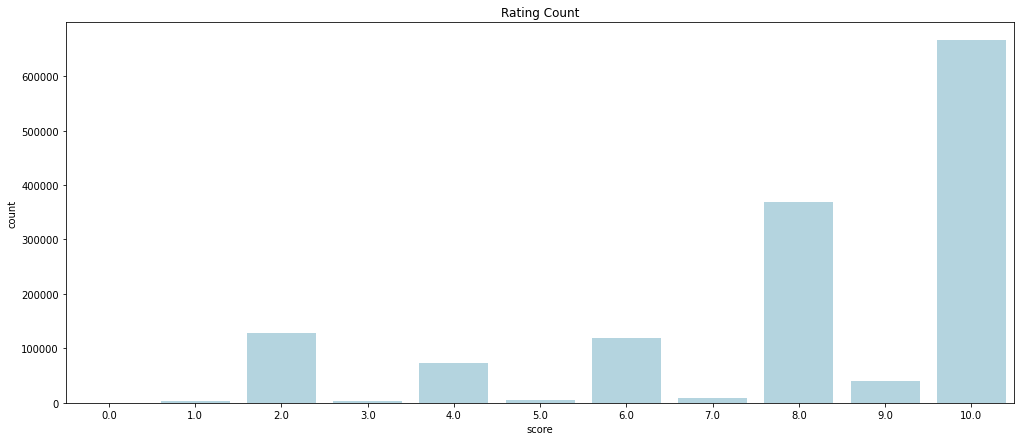

In [22]:

plt.figure(figsize=(17,7))
sns.countplot('score',data=df,color='LightBlue')
plt.title('Rating Count')
plt.show()

**Insight:** Users has given rating 10 more number of times.

Rating count per year.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


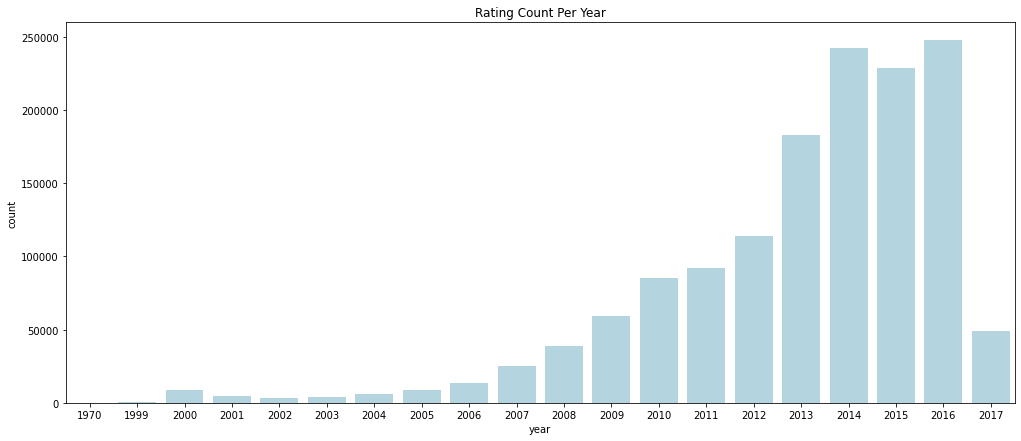

In [23]:
plt.figure(figsize=(17,7))
sns.countplot('year',data=df,color='LightBlue')
plt.title('Rating Count Per Year')
plt.show()

**Insight:**  2016 has most number of ratings followed by 2014.

Rating Count Per Month

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


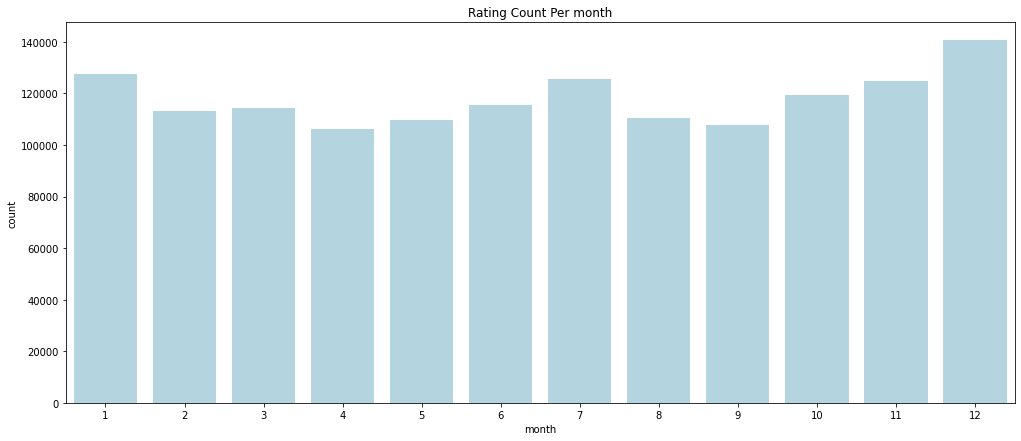

In [24]:
plt.figure(figsize=(17,7))
sns.countplot('month',data=df,color='LightBlue')
plt.title('Rating Count Per month')
plt.show()

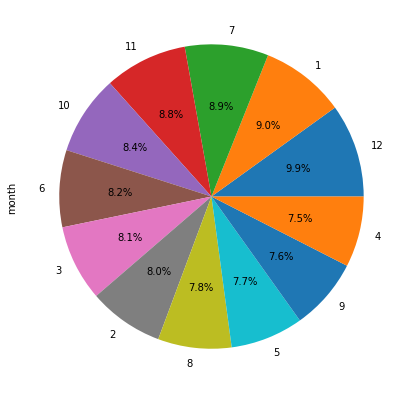

In [25]:
# Distribution in %

plt.figure(figsize=(17,7))
df['month'].value_counts().plot.pie(autopct='%1.1f%%')
plt.show()

**Insight:** Mostly all months has equal distributions.
January and December distributions are high compared to other months. Small hike in December and January may be due to festival offers.

Creating Day Name column and showing dsitribution based on days.

In [26]:
df['Day_Name']=df['date'].dt.day_name()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


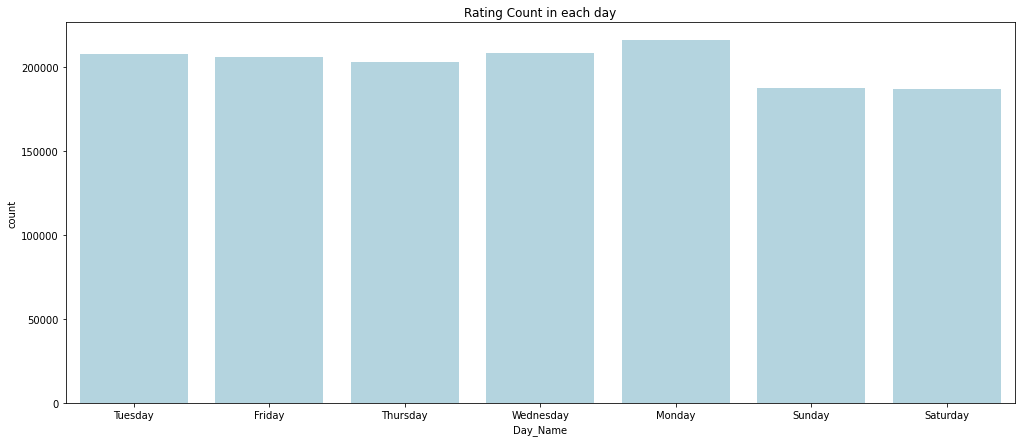

In [27]:
plt.figure(figsize=(17,7))
sns.countplot('Day_Name',data=df,color='LightBlue')
plt.title('Rating Count in each day')
plt.show()

**Insight:** Weekday sales are more compared to weekends.

**Dropping Irrelevant Columns**

In [28]:
df.drop(['extract','domain','phone_url','date','lang','country','source','domain','year','month','Day_Name'],axis=1,inplace=True)

In [29]:
df.shape

(1415133, 3)

Now shape of data is 1415133 rows and 3 columns

**Checking Duplicates**

In [30]:
df.drop_duplicates(inplace=True)

In [31]:
df.shape

(1227419, 3)

**Keeping only 1000000 data samples for our Analysis and Model Building.**

In [32]:
df_sample=df.sample(n =1000000,random_state=612)

In [33]:
df_sample.shape

(1000000, 3)

**STEP 2:** 

**1.   Identify the most rated features**.


In [34]:
df_sample['product'].value_counts()[:10]

OnePlus 3 (Graphite, 64 GB)               1811
Lenovo Vibe K4 Note (White,16GB)          1737
Nokia N95                                 1496
Lenovo Vibe K4 Note (Black, 16GB)         1469
Samsung Galaxy J3 (8GB)                   1465
OnePlus 3 (Soft Gold, 64 GB)              1451
Samsung Galaxy S7 edge 32GB (Verizon)     1413
Nokia 5800 XpressMusic                    1378
Samsung Galaxy S6 zwart / 32 GB           1318
Samsung Galaxy S7 edge 32GB (T-Mobile)    1313
Name: product, dtype: int64

**Answer**: One Plus 3 is the most rated product followed by Lenovo Lenovo Vibe K4 Note and Nokia N95.

**2.  Identify the users with most number of reviews**



In [35]:
df_sample['author'].value_counts()[:10]

Amazon Customer    24341
Cliente Amazon      5208
Client d'Amazon     2198
Amazon Kunde        1632
Anonymous           1572
David                759
Alex                 656
Daniel               566
Marco                557
Andrea               543
Name: author, dtype: int64

**Answer:** "Amazon Customer" has given higest number of reviews. Top 4 places are Amazon users with anonymous names.

3. Select the data with products having more than 50 ratings and users who have given more than 50 ratings. Report the shape of the final 
dataset.




In [36]:
#selecting user count greater than 50
counts=pd.value_counts(df_sample['author']) 

In [37]:
df_sample=df_sample[(df_sample['author'].isin(counts[counts>50].index)) ]

In [38]:
df_sample['author'].value_counts(ascending=True)[:5] #checking minimum user count

zercan74    51
Ashish      51
Ankit       51
emre        51
Vijay       51
Name: author, dtype: int64

In [40]:
# selecting products which had atleast 50 reviews.

countsp=pd.value_counts(df_sample['product'])

df_sample=df_sample[ df_sample['product'].isin(countsp[countsp>50].index)]

In [41]:
#checking minimum product count
df_sample['product'].value_counts(ascending=True)[:5] 

Apple iPhone 5 Unlocked Cellphone, 32GB, Black             51
Samsung Galaxy S7 Edge goud / 32 GB                        51
Nokia 101 Premium Black                                    52
Samsung Galaxy J5 Smartphone, Oro [Italia]                 52
Samsung Galaxy Centura Android Prepaid Phone (TracFone)    53
Name: product, dtype: int64

**Final Shape**

In [42]:
df_sample.shape

(7232, 3)

###  **Build a popularity based model and recommend top 5 mobile phones.**

Top 5 Mobile Phones

In [43]:
df_sample.groupby('product')['score'].mean().sort_values(ascending=False)[:5]

product
APPLE iPhone 6s Plus - 128 GB, Rose Gold                                                                                                                9.321429
LG D802 G2 Smartphone, 16 GB, Nero [Italia]                                                                                                             9.288136
Lenovo Motorola Moto G Smartphone, Display HD 4,5", Processore Qualcomm, Memoria 8 GB, MicroSIM, Android 4.4 OS, Fotocamera da 5 MP, Nero [Germania]    9.238095
Sim Free Motorola Moto G 4th Generation Mobile Phone - Black                                                                                            9.233333
Samsung Galaxy A5 2016 Smartphone LTE, 16GB, Nero                                                                                                       9.068966
Name: score, dtype: float64

**Insight:**  

1.   APPLE iPhone 6s Plus - 128 GB, Rose Gold is the most popular rated product with the score of 9.321429.
2.   The Top 5 score ranges between 9.321429 and 9.068966.



### **Collaborative Filtering**

Creating dataframe with only author,product and score column

In [44]:
df_col=df_sample[['author','product','score']]

df_col.head()

,author,product,score
24400,Sam,"Lenovo Motorola Moto E Smartphone, Display 4.3...",10.0
50899,Helen,"APPLE iPhone 7 - Silver, 32 GB",8.0
238492,salvatore,"Asus ZenFone 2 Laser 5.5"" Smartphone, 16 GB, D...",10.0
337637,Lorenzo,"Lenovo Motorola Moto G Smartphone, Display HD ...",10.0
135226,Ð Ð¾Ð¼Ð°Ð½,Sony Xperia C (ÑÐµÑÐ½ÑÐ¹),7.0


Using Surprise library to build collaborative filtering model.

In [45]:
reader = Reader(rating_scale=(1, 10))

In [46]:
data= Dataset.load_from_df(df_col[['author','product','score']],reader)

 Points to Note:
- 1) Trainset is no longer a pandas dataframe. Rather, it's a specific datatypes defined by the Surprise library


- 2) Author and Product in the pandas dataframe can contain any value (either string/integer etc). However, Trainset convert these raw ids into numeric indexes called as "inner id"


- 3) Methods are provided to convert raw id to inner id and vice versa

**Splitting data into train and test**

In [47]:
trainset, testset = train_test_split(data, test_size=.25,random_state=123)

### **Building Collaborative Filtering Model using SVD.**

In [48]:
svd_model = SVD(n_factors=5,biased=False)
svd_model.fit(trainset)

In [49]:
# Creating copy for future use maybe.

df_sam=df_col.copy()

Predicting values for Test data

In [50]:
test_pred_svd = svd_model.test(testset)

Compute RMSE


In [51]:
accuracy.rmse(test_pred_svd)

RMSE: 2.1979


2.1978682004870254

**Recommeding Top 10 products for the Unknown customers**

In [52]:
df_sam['est']=df_sam['product'].apply(lambda x: svd_model.predict('avd',x).est)
df_sam = df_sam.sort_values(by=['est'], ascending=False)
df_sam.head(10)

,author,product,score,est
24400,Sam,"Lenovo Motorola Moto E Smartphone, Display 4.3...",10.0,8.421091
207855,ÐÐ»ÐµÐºÑÐ°Ð½Ð´ÑÐ°,Samsung Galaxy S4 GT-I9500 16GB (Ð±ÐµÐ»ÑÐ¹),10.0,8.421091
174437,Ð¡ÐµÑÐ³ÐµÐ¹,Samsung Galaxy S4 mini Duos GT-I9192 (Ð±ÐµÐ»ÑÐ¹),8.0,8.421091
100923,ÐÐ»ÐµÐºÑÐµÐ¹,Sony Xperia Z1 Compact (ÑÐµÑÐ½ÑÐ¹),10.0,8.421091
184427,laura,Huawei P8 Lite-AM08 - Pack Smartphone Huawei P...,8.0,8.421091
196533,ÐÐºÐ°ÑÐµÑÐ¸Ð½Ð°,Sony Xperia L (ÐºÑÐ°ÑÐ½ÑÐ¹),10.0,8.421091
131490,Julie,"SAMSUNG Galaxy A3 (2017) - 16 GB, Black",10.0,8.421091
178422,Claudia,Huawei P8 Lite wit / 16 GB,8.0,8.421091
134680,ÐÐ²Ð°Ð½,Sony Xperia C (ÑÐ¸Ð¾Ð»ÐµÑÐ¾Ð²ÑÐ¹),7.0,8.421091
304119,Laura,"Asus ZenFone 2 Smartphone, Schermo da 5.5"" Ful...",10.0,8.421091


### **Building Collaborative Filtering Model using KNNWithMeans.**

**User Based Model**

In [53]:
algo = KNNWithMeans(k=50, sim_options={'name': 'pearson_baseline', 'user_based': True})
algo.fit(trainset)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


Predicting average rating for test data

In [54]:
# run the trained model against the testset
test_pred_user = algo.test(testset)

In [55]:
test_pred_user

[Prediction(uid='Ð¡ÐµÑ\x80Ð³ÐµÐ¹', iid='Samsung N7100 Galaxy Note II 16GB (Ð±ÐµÐ»Ñ\x8bÐ¹)', r_ui=9.0, est=6.318416183037064, details={'actual_k': 29, 'was_impossible': False}),
 Prediction(uid='Alexander', iid='Apple iPhone 5s GSM Unlocked Cellphone, 16 GB, Space Gray', r_ui=6.0, est=1.5303030303030303, details={'actual_k': 1, 'was_impossible': False}),
 Prediction(uid='Ð\x9cÐ¸Ñ\x85Ð°Ð¸Ð»', iid='Sony Xperia SP (Ñ\x87ÐµÑ\x80Ð½Ñ\x8bÐ¹)', r_ui=10.0, est=8.73862764887259, details={'actual_k': 30, 'was_impossible': False}),
 Prediction(uid='Federica', iid='LG D802 G2 Smartphone, 16 GB, Nero [Italia]', r_ui=10.0, est=10, details={'actual_k': 18, 'was_impossible': False}),
 Prediction(uid='Davide', iid='Lenovo Motorola Moto G Smartphone, 4,5 pollici display HD, processore Qualcomm, memoria 16GB, MicroSIM, Android 4.3 OS, fotocamera da 5 MP, Nero [Germania]', r_ui=8.0, est=9.030186273857153, details={'actual_k': 49, 'was_impossible': False}),
 Prediction(uid='Julie', iid='SAMSUNG Galaxy A3 (20

Evaluation-RMSE

In [56]:
# getting RMSE
print("User-based Model : Test Set")
accuracy.rmse(test_pred_user, verbose=True)

User-based Model : Test Set
RMSE: 2.4338


2.433815763757554

Test Predictions for User Model

In [57]:
pred_df=pd.DataFrame(test_pred_user)

In [58]:
pred_df.head()

,uid,iid,r_ui,est,details
0,Ð¡ÐµÑÐ³ÐµÐ¹,Samsung N7100 Galaxy Note II 16GB (Ð±ÐµÐ»ÑÐ¹),9.0,6.318416,"{'actual_k': 29, 'was_impossible': False}"
1,Alexander,"Apple iPhone 5s GSM Unlocked Cellphone, 16 GB,...",6.0,1.530303,"{'actual_k': 1, 'was_impossible': False}"
2,ÐÐ¸Ñ Ð°Ð¸Ð»,Sony Xperia SP (ÑÐµÑÐ½ÑÐ¹),10.0,8.738628,"{'actual_k': 30, 'was_impossible': False}"
3,Federica,"LG D802 G2 Smartphone, 16 GB, Nero [Italia]",10.0,10.000000,"{'actual_k': 18, 'was_impossible': False}"
4,Davide,"Lenovo Motorola Moto G Smartphone, 4,5 pollici...",8.0,9.030186,"{'actual_k': 49, 'was_impossible': False}"


#### **Steps in User based Collaborative filtering model.**


1.   Finding neighbours for the particular user based on the similarity measure.
2.   50 neighbours are selected in this project.
3.   Filter out the products which are already rated by the user
4.   For remaining product find out the mean rating and sort the ratings in descending order and recommend to the user.
5.   So user may get recommendation for the product which are highly rated by the user like him.
6.   Also average rating for the product which is not rated by user can be estimated by its neighbours.








### **Item Based Model**

**For Item based model all the above steps are same except user_based is set to False**

In [59]:
algo_item = KNNWithMeans(k=50, sim_options={'name': 'pearson_baseline', 'user_based': False})
algo_item.fit(trainset)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


Predicting Average Rating for test data

In [60]:
# run the trained model against the testset
test_pred_item = algo_item.test(testset)

In [61]:
test_pred_item

[Prediction(uid='Ð¡ÐµÑ\x80Ð³ÐµÐ¹', iid='Samsung N7100 Galaxy Note II 16GB (Ð±ÐµÐ»Ñ\x8bÐ¹)', r_ui=9.0, est=5.511989840290157, details={'actual_k': 33, 'was_impossible': False}),
 Prediction(uid='Alexander', iid='Apple iPhone 5s GSM Unlocked Cellphone, 16 GB, Space Gray', r_ui=6.0, est=5.778152731625589, details={'actual_k': 2, 'was_impossible': False}),
 Prediction(uid='Ð\x9cÐ¸Ñ\x85Ð°Ð¸Ð»', iid='Sony Xperia SP (Ñ\x87ÐµÑ\x80Ð½Ñ\x8bÐ¹)', r_ui=10.0, est=8.797268987393043, details={'actual_k': 17, 'was_impossible': False}),
 Prediction(uid='Federica', iid='LG D802 G2 Smartphone, 16 GB, Nero [Italia]', r_ui=10.0, est=9.255813953488373, details={'actual_k': 0, 'was_impossible': False}),
 Prediction(uid='Davide', iid='Lenovo Motorola Moto G Smartphone, 4,5 pollici display HD, processore Qualcomm, memoria 16GB, MicroSIM, Android 4.3 OS, fotocamera da 5 MP, Nero [Germania]', r_ui=8.0, est=9.593921768041566, details={'actual_k': 7, 'was_impossible': False}),
 Prediction(uid='Julie', iid='SAMSUNG 

Evaluation-RMSE

In [62]:
# getting RMSE
print("Item-based Model : Test Set")
accuracy.rmse(test_pred_item, verbose=True)

Item-based Model : Test Set
RMSE: 2.4398


2.439844366398687

**Insight:** Slightly better than User Based Model.

**Test Predictions for Item Based Model**

In [63]:
pred_df_item=pd.DataFrame(test_pred_item)

In [64]:
pred_df_item.head()

,uid,iid,r_ui,est,details
0,Ð¡ÐµÑÐ³ÐµÐ¹,Samsung N7100 Galaxy Note II 16GB (Ð±ÐµÐ»ÑÐ¹),9.0,5.511990,"{'actual_k': 33, 'was_impossible': False}"
1,Alexander,"Apple iPhone 5s GSM Unlocked Cellphone, 16 GB,...",6.0,5.778153,"{'actual_k': 2, 'was_impossible': False}"
2,ÐÐ¸Ñ Ð°Ð¸Ð»,Sony Xperia SP (ÑÐµÑÐ½ÑÐ¹),10.0,8.797269,"{'actual_k': 17, 'was_impossible': False}"
3,Federica,"LG D802 G2 Smartphone, 16 GB, Nero [Italia]",10.0,9.255814,"{'actual_k': 0, 'was_impossible': False}"
4,Davide,"Lenovo Motorola Moto G Smartphone, 4,5 pollici...",8.0,9.593922,"{'actual_k': 7, 'was_impossible': False}"


**Insight:**  

1.   Rmse for Item based model is higher than user based model.
2.   SVD has less rmse value compared to others, may be change in paramters might provide better results.


### **Cross Validation.**

In [65]:
sim_options = {
    "name": ["msd", "cosine","pearson_baseline"],
    "min_support": [3, 4, 5],
    "user_based": [False, True],
}

In [66]:
param_grid = {'k':[40,50,60],"sim_options": sim_options}

Grid search CV to get best features.

In [67]:
gs = GridSearchCV(KNNWithMeans, param_grid, measures=["rmse", "mae"], cv=5)
gs.fit(data)

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computi

Best Parameters using Grid Search.

In [68]:
print(gs.best_score["rmse"])
print(gs.best_params["rmse"])

2.1284102558733253
{'k': 60, 'sim_options': {'name': 'cosine', 'min_support': 3, 'user_based': False}}


**Insight:** Best Hyperparameters are: {'name': 'cosine', 'min_support': 3, 'user_based': False}

**Final Colloborative Model with Best Parameters.**

In [69]:
Final_Model = KNNWithMeans(k=40, sim_options={'name': 'cosine', 'min_support':3 ,'user_based': False})
Final_Model.fit(trainset)
# run the trained model against the testset
Final_Model_Pred = algo_item.test(testset)
accuracy.rmse(Final_Model_Pred, verbose=True)

Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 2.4398


2.439844366398687

**Insight:** The Fianl RMSE score after applying BEst Hyperparametrs is : **2.4398**

### **Cross Validation on SVD Model.**

In [70]:
param_grid = {'n_factors':[5,10],'n_epochs': [5, 10], 'lr_all': [0.002, 0.005],
              'reg_all': [0.4, 0.6]}
gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=5)

gs.fit(data)

#cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

In [71]:
# best RMSE score
print(gs.best_score['rmse'])

# combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

2.0162023561371436
{'n_factors': 5, 'n_epochs': 5, 'lr_all': 0.005, 'reg_all': 0.4}


**Insight:**

1.   The Fianl RMSE score after applying BEst Hyperparametrs is : **2.01620**
2.   When Using cross validated best paramters SVD, RMSE score is less compared to others



### **In what business scenario you should use popularity based Recommendation Systems?**

**When we have new user who doesn't watch any of the movies we cant able to find its neighbours . In this case popularity based recommendation is used.As the name suggests Popularity based recommendation system works with the trend. It basically uses the items which are in trend right now. For example, if any product which is usually bought by every new user then there are chances that it may suggest that item to the user who just signed up.**

### **In what business scenario you should use CF based Recommendation Systems ?**


> **When user is not new user and he also got some neighbours. The idea behind collaborative filtering is to consider users’ opinions on different products and recommend the best product to each user based on the user’s previous rankings and the opinion of other similar types of users.It ha two types user-based and item-based.**

**Steps in user Bsed colloborative filtering**

> **1) Finding neighbours for the particular user based on the similarity measure.**

> **2) 50 neighbours are selected in this project.**

> **3) Filter out the movies which are already watched by the user**

> **4) For remaining movies find out the mean rating and sort the movies in descending order and recommend to the user.**

> **5) So user may get recommendation for the movie which are highly rated by the user like him.**

> **6) Also average rating for the movie which is not watched by user can be estimated by its neighbours.**

**For item based every steps are based on items.**

###  **What other possible methods can you think of which can further improve the recommendation for different users ?**

> **In some cases we may face cold stard or gray shep problem.In such cases, Combining any two filtering methods may help in improving the recommendation filter. These are known as Hybrid filtering.**

> **IN Hybrid filtering, which combines two or more filtering techniques in different ways in order to increase the accuracy and performance of recommender systems has been proposed. These techniques combine two or more filtering approaches in order to harness their strengths while leveling out their corresponding weaknesses.**

> **When new users signs in, we may recommend using popularity based filtering and once users starts watching the movies then it can be switched to user based or item based . This can improve the recommendation.**